In [102]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d, LinearNDInterpolator

# import h5py
# from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb

import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

from astropy.io import fits

In [2]:
%run "/Users/macprorac2/Documents/Gabriel Dima's Group/NPGMI-src/NPGMI Engine.ipynb"

### LANL Experiment Data 

In [3]:

# h = 16e-6
h = 8.53e-6
L = 425.345e-2
L1 = 212.52e-2
p = 3e-6

pxl_to_m = 50e-6

d_oam4 = np.arange(7.5,17.5 + 2.5,2.5)*1e-3
d_oam7 = np.repeat(d_oam4,3)[:-2] + 1e-3

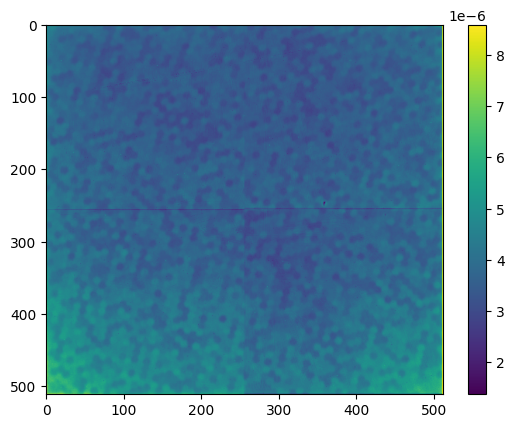

In [4]:
normed = tfl.imread("/Users/macprorac2/Documents/Gabriel Dima's Group/Data/LANL Experiment/detector_norm_sum.tiff")

normed_max = np.max(normed)

normed = np.concatenate((np.ones((512,1))*normed_max,normed,np.ones((512,1))*normed_max),axis = -1)

plt.colorbar(plt.imshow(normed, aspect = "auto"))
# plt.xlim(0,2)
plt.show()

In [5]:
oam4basepath = r"/Users/macprorac2/Documents/Gabriel Dima's Group/Data/LANL Experiment/OAM4D00"
oam7basepath = r"/Users/macprorac2/Documents/Gabriel Dima's Group/Data/LANL Experiment/OAM7D"


spec_data = np.genfromtxt("LANL lam dist.csv", delimiter=",", skip_header = 1)[:,-2:]

reset_cutoff = (np.argmin(np.abs(spec_data[:,0]-3.5)),2210)

spec_data = spec_data[reset_cutoff[0]:reset_cutoff[1]]

pairs = [spec_data[0]]

for ind, pair in enumerate(spec_data[1:]):
    # if np.abs(pair[0] - pairs[-1][0]) > 0.1 or (np.abs(pair[0] - pairs[-1][0]) > 0.01 and (3.9 < pair[0] < 4.1)):
    if np.abs(pair[0] - pairs[-1][0]) > 0.03:
        
        pairs.append(pair)
    
# lam, plam = np.array(pairs)[::2].T
lam, plam = np.array(pairs).T

print(lam.shape)
lam *= 1e-10
plam /= np.trapz(plam, x = lam)
                            
lamlocs = np.argmin(np.abs(spec_data[:,0][:,None] - lam[None,:]*1e10), axis = 0)




(185,)


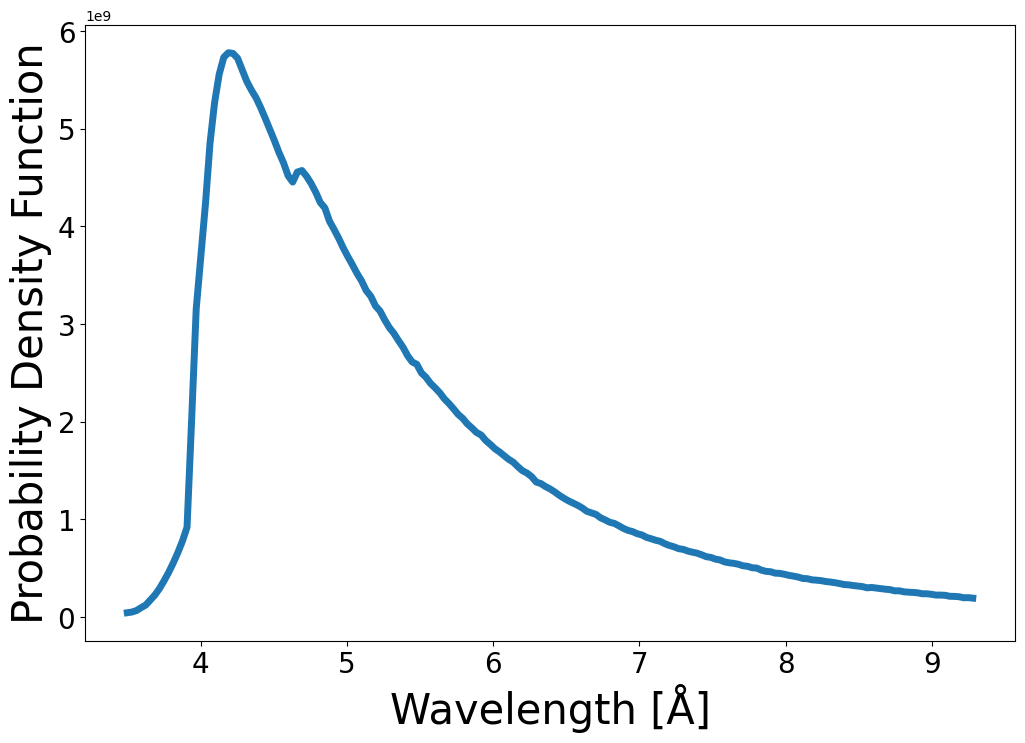

In [6]:
fig, ax1 = plt.subplots(figsize  = (12,8))

ax1.plot(lam*1e10, plam, lw = 5)


ax1.set_xlabel("Wavelength [Å]", fontsize = 30)
ax1.set_ylabel("Probability Density Function", fontsize = 30)
ax1.tick_params(labelsize = 20)

# ax1.legend(fontsize = 20, loc = "upper center")
# fig.savefig("LANL Wavelength Distribution.png")

plt.show()
plt.close(fig)

In [7]:
all_oam4_imgs_partsummed = [Image.fromarray(np.sum([fits.open((oam4basepath + "%d" + "/datafiles/" + "oam4D00%d_0"\
                            + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data / normed.T for i in range(reset_cutoff[0],reset_cutoff[1])], axis = 0)) for d in range(5)]

In [8]:
all_oam7_imgs_partsummed = [Image.fromarray(np.sum([fits.open((oam7basepath + "0"*(3 - len(str(d))) + "%d/datafiles/" + "Dscan_" + "0"*(3 - len(str(d)))+ "%d_0"\
                            + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data / normed.T for i in range(reset_cutoff[0],reset_cutoff[1])], axis = 0)) for d in range(13)]

### Alignment

In [9]:
oam4rotdegs = [4.5,3,2.5,2,2]

all_oam4_imgs_partsummed_rotated = [img.copy().rotate(oam4rotdegs[i]) for i, img in enumerate(all_oam4_imgs_partsummed)]
ind = 2
img = all_oam4_imgs_partsummed_rotated[ind]
# img = all_oam4_imgs_partsummed[ind]


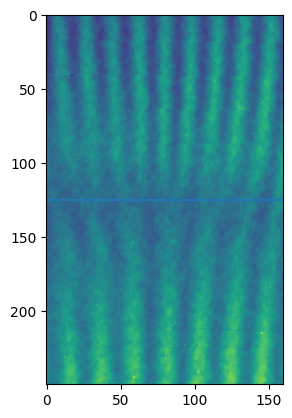

In [10]:
# unequal sizes causes y-axis effect in fft2d 
img_fft2 = np.abs(fftshift(fft2(np.array(img)[55:215, 40:290])))

plt.axhline(125)
plt.imshow(np.array(img)[55:215, 40:290].T)


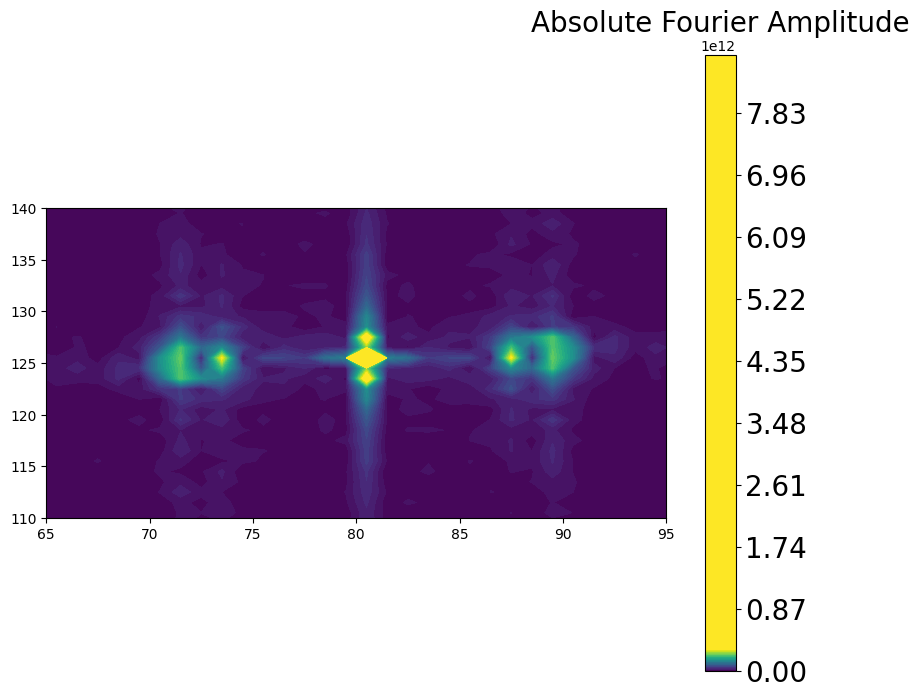

In [11]:
fig, ax = plt.subplots(figsize = (10,8))



c = ax.contourf(img_fft2.T, levels = 1000, origin = "lower",)



cbar = fig.colorbar(c,) # format = "%.1f")
cbar.ax.tick_params(labelsize = 20)
cbar.ax.set_title("Absolute Fourier Amplitude", fontsize = 20)
c.set_clim(0,3e11)

# ax.set_xticks(d_oam4*1e3)
# ax.set_xticklabels(d_oam4_labels, fontsize = 20)

# ax.set_yticks(np.arange(4,10))
# ax.set_yticklabels(np.arange(4,10), fontsize = 20)

# ax.set_xlabel(r"$d$ [mm]", fontsize = 20)
# ax.set_ylabel("Wavelength Range [Å]", fontsize = 20)


ax.set_xlim(65,95)
ax.set_ylim(110,140)
ax.set_aspect(0.5)

fig.savefig("datafft2dsmooth.png",bbox_inches = "tight")
plt.show()
plt.close(fig)



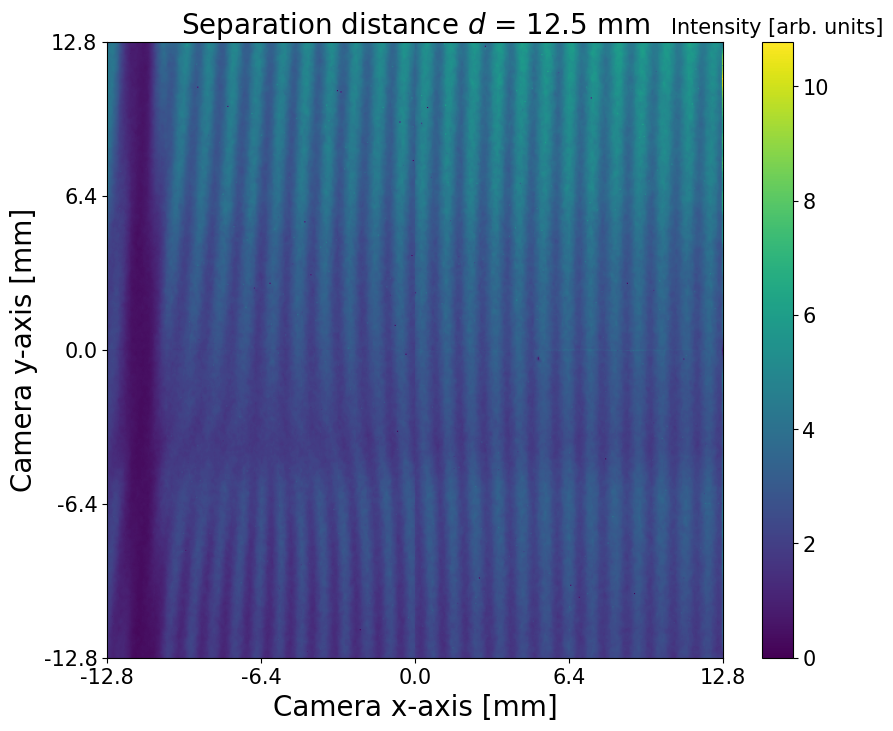

In [12]:
fig, ax = plt.subplots(figsize = (10,8))

# fig.colorbar(ax.imshow(np.array(lam_oam4_imgs[19][0]).T, origin = "upper"))
ind = 2

n_pxls = 512
camx = camy = np.linspace(-n_pxls,n_pxls,n_pxls)*pxl_to_m*1e3/2
c = ax.imshow(np.array(all_oam4_imgs_partsummed[ind]).T/1e8, origin = "lower", extent = [camx[0],camx[-1],camy[0],camy[-1]])
cbar = fig.colorbar(c)
cbar.ax.tick_params(labelsize = 15)
cbar.ax.set_title("Intensity [arb. units]", fontsize = 15)
ax.set_xlabel("Camera x-axis [mm]", fontsize = 20)

camxlabels = np.linspace(camx[0],camx[-1],5)
camylabels = np.linspace(camy[0],camy[-1],5)

ax.set_xticks(camxlabels,["%.1f" % i for i in camxlabels], fontsize = 15)

ax.set_ylabel("Camera y-axis [mm]", fontsize = 20)

ax.set_yticks(camylabels,["%.1f" % i for i in camylabels], fontsize = 15)
ax.set_title("Separation distance $d$ = %.1f mm" % (d_oam4[ind]*1e3), fontsize = 20)
# fig.savefig("OAM4DataForkIntensityd=%.1fmm.png"%(d_oam4[ind]*1e3) )
plt.show()
plt.close(fig)

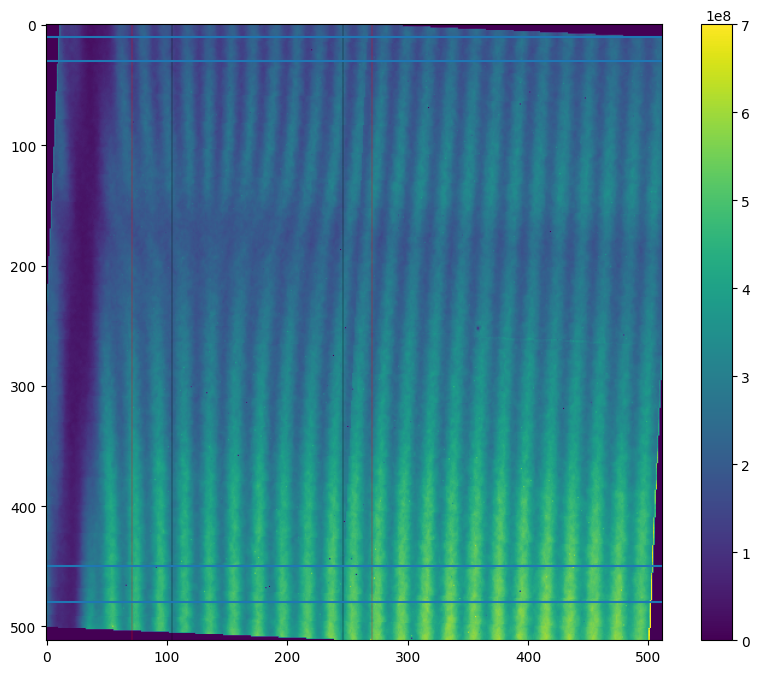

In [13]:
fig, ax = plt.subplots(figsize = (10,8))
c = ax.imshow(np.array(img).T, origin = "upper",clim = (0,7e8))
fig.colorbar(c)
# ax.axvline(127, color = "purple", lw = 0.25)

oam4forkranges = [(70,323), (68,313), (71,270), (59,243), (57,231)]
oam4noforkranges = [(122,290), (112,287),(104,246), (87,222), (82,212)]

[ax.axvline(i,color = "red", lw = 0.25) for i in oam4forkranges[ind]]
[ax.axvline(i,color = "black", lw = 0.25) for i in oam4noforkranges[ind]]

ax.axhline(10)
ax.axhline(30)
ax.axhline(450)
ax.axhline(480)


plt.show()
# fig.savefig("tiltedfork.jpg")
plt.close(fig)

In [14]:
oam7rotdegs = [4,4,4.25,2.5,2.5,3,2.5,2.25,2.25,2,2.25,2.25,2]

all_oam7_imgs_partsummed_rotated = [img.copy().rotate(oam7rotdegs[i]) for i, img in enumerate(all_oam7_imgs_partsummed)]
ind = 4
img = all_oam7_imgs_partsummed_rotated[ind]


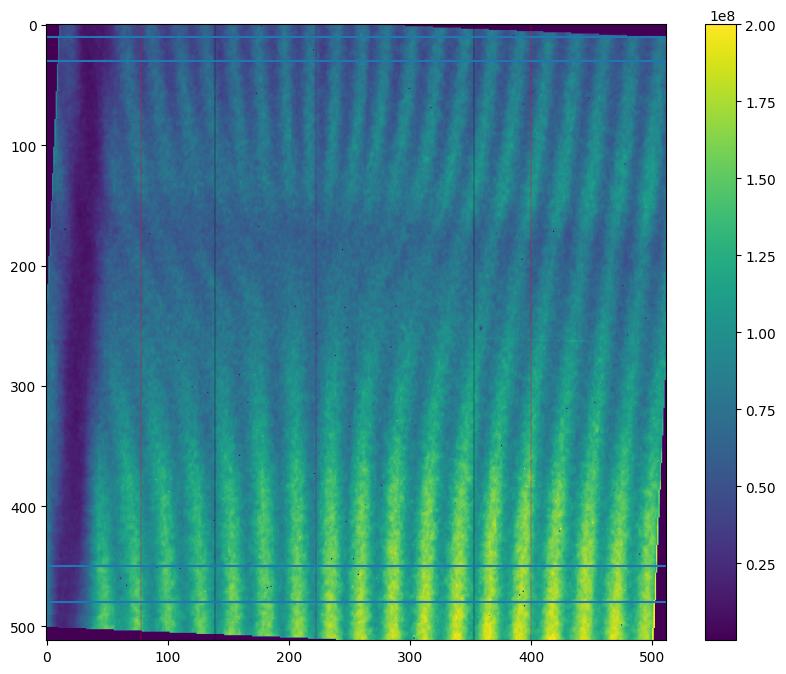

In [15]:
fig, ax = plt.subplots(figsize = (10,8))
c = ax.imshow(np.array(img).T, aspect = "auto", clim = (1,2e8))
fig.colorbar(c)
ax.axvline(222, color = "purple", lw = 0.25)

oam7forkranges = [(98,396), (75,400), (79,404), (81,402), (78,400), (80,402), (67,404),\
                  (65,401), (63,401), (69,401),(69,401),(68,400),(63,296)]

oam7noforkranges = [(186,334), (153,338),(155,341), (143,354), (139,353), (136,352),(110,365),\
                (110,365), (110,363), (107,369),(104,367),(104,367),(79,245)]

[ax.axvline(i,color = "red", lw = 0.25) for i in oam7forkranges[ind]]
[ax.axvline(i,color = "black", lw = 0.25) for i in oam7noforkranges[ind]]

ax.axhline(10)
ax.axhline(30)
ax.axhline(450)
ax.axhline(480)

plt.show()
# fig.savefig("tiltedfork.jpg")
plt.close(fig)

In [16]:
    
all_oam4_fork_subregion = [np.array(img)[oam4forkranges[i][0]:oam4forkranges[i][1],10:30] for i, img in enumerate(all_oam4_imgs_partsummed_rotated)]
all_oam4_nofork_subregion = [np.array(img)[oam4noforkranges[i][0]:oam4noforkranges[i][1],450:480] for i, img in enumerate(all_oam4_imgs_partsummed_rotated)]

all_oam4_fork_intens = [np.sum(sub, axis = -1) for sub in all_oam4_fork_subregion]
all_oam4_nofork_intens = [np.sum(sub, axis = -1) for sub in all_oam4_nofork_subregion]


In [17]:
all_oam7_fork_subregion = [np.array(img)[oam7forkranges[i][0]:oam7forkranges[i][1],10:30] for i, img in enumerate(all_oam7_imgs_partsummed_rotated)]
all_oam7_nofork_subregion = [np.array(img)[oam7noforkranges[i][0]:oam7noforkranges[i][1],450:480] for i, img in enumerate(all_oam7_imgs_partsummed_rotated)]

all_oam7_fork_intens = [np.sum(sub, axis = -1) for sub in all_oam7_fork_subregion]
all_oam7_nofork_intens = [np.sum(sub, axis = -1) for sub in all_oam7_nofork_subregion]


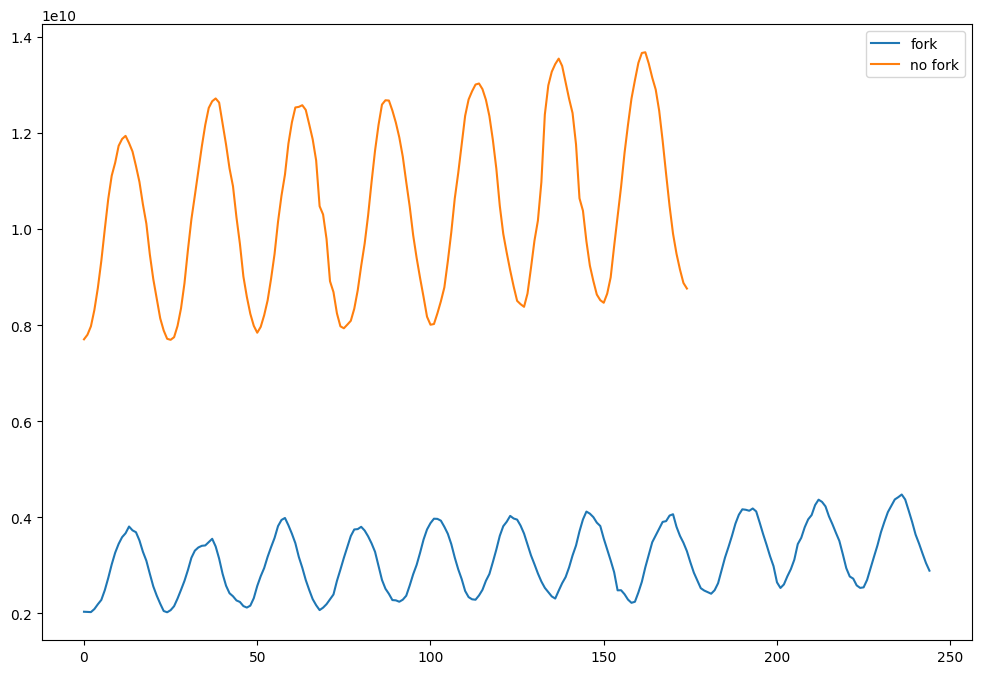

In [18]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(all_oam4_fork_intens[1], label = "fork")
ax1.plot(all_oam4_nofork_intens[1], label = "no fork")
ax1.legend()
plt.show()
plt.close(fig)

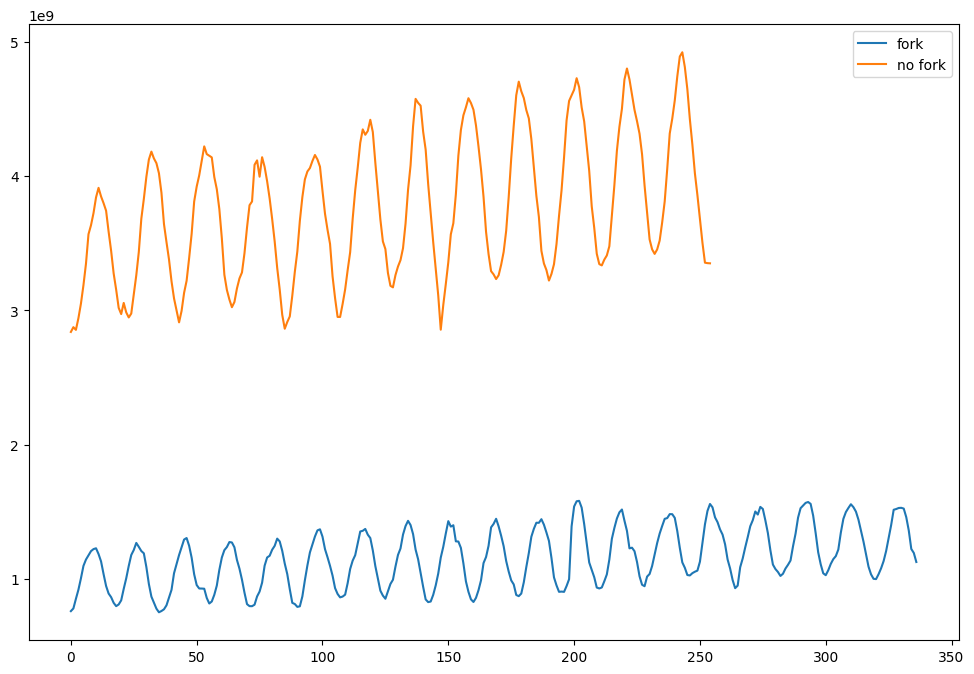

In [19]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(all_oam7_fork_intens[6], label = "fork")
ax1.plot(all_oam7_nofork_intens[6], label = "no fork")
ax1.legend()
plt.show()
plt.close(fig)

### Contrast Fitting

In [20]:

oam4_fork_fitparams, oam4_fork_error = np.moveaxis([best_fit_moire_period_with_error(cosine_func, \
                                        np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam4[i], use_abs_sigma = False) for i, intens in enumerate(all_oam4_fork_intens)], -2, 0)

oam4_nofork_fitparams, oam4_nofork_error = np.moveaxis([best_fit_moire_period_with_error(cosine_func,\
                                        np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam4[i], use_abs_sigma = False) for i, intens in enumerate(all_oam4_nofork_intens)], -2,0)

In [21]:
oam4_fork_error[...,2]/ oam4_fork_fitparams[...,2]

array([0.00177718, 0.00129253, 0.00130445, 0.00160365, 0.00237001])

In [22]:
print_shapes(oam4_nofork_fitparams, oam4_nofork_error)

(5, 4) (5, 4) 



In [23]:
oam7_fork_fitparams, oam7_fork_error = np.moveaxis([best_fit_moire_period_with_error(cosine_func, \
                                        np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam7[i], use_abs_sigma = False) for i, intens in enumerate(all_oam7_fork_intens)], -2, 0)

oam7_nofork_fitparams, oam7_nofork_error = np.moveaxis([best_fit_moire_period_with_error(cosine_func,\
                                        np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam7[i], use_abs_sigma = False) for i, intens in enumerate(all_oam7_nofork_intens)], -2,0)

In [24]:
print_shapes(oam7_nofork_fitparams, oam7_nofork_error)

(13, 4) (13, 4) 



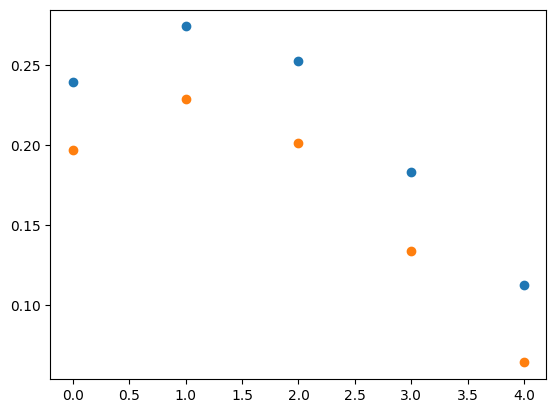

In [25]:
plt.plot(np.abs(oam4_fork_fitparams[...,1]/oam4_fork_fitparams[...,0]), "o")
plt.plot(np.abs(oam4_nofork_fitparams[...,1]/oam4_nofork_fitparams[...,0]), "o")
plt.show()

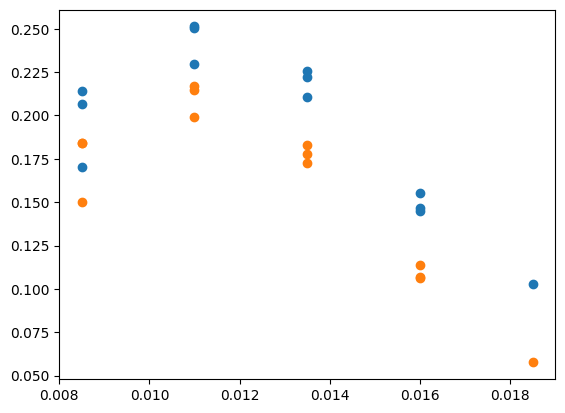

In [26]:
plt.plot(d_oam7,np.abs(oam7_fork_fitparams[...,1]/oam7_fork_fitparams[...,0]), "o")
plt.plot(d_oam7,np.abs(oam7_nofork_fitparams[...,1]/oam7_nofork_fitparams[...,0]), "o")
plt.show()

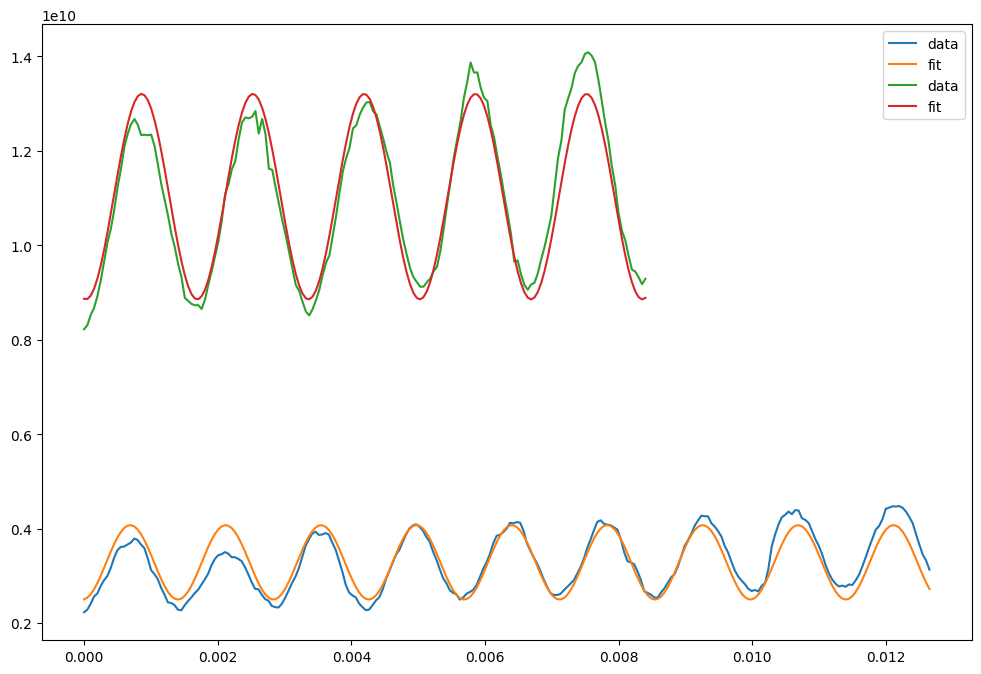

In [27]:
fig, ax1 = plt.subplots(figsize = (12,8))
ind = 0
intens = all_oam4_fork_intens[ind]

x = np.linspace(0,len(intens),len(intens))*pxl_to_m
ax1.plot(x,intens, label = "data")
ax1.plot(x, cosine_func(x,*oam4_fork_fitparams[ind]), label = "fit")

intens = all_oam4_nofork_intens[ind]

x = np.linspace(0,len(intens),len(intens))*pxl_to_m
ax1.plot(x,intens, label = "data")
ax1.plot(x, cosine_func(x,*oam4_nofork_fitparams[ind]), label = "fit")

ax1.legend()
plt.show()
plt.close(fig)

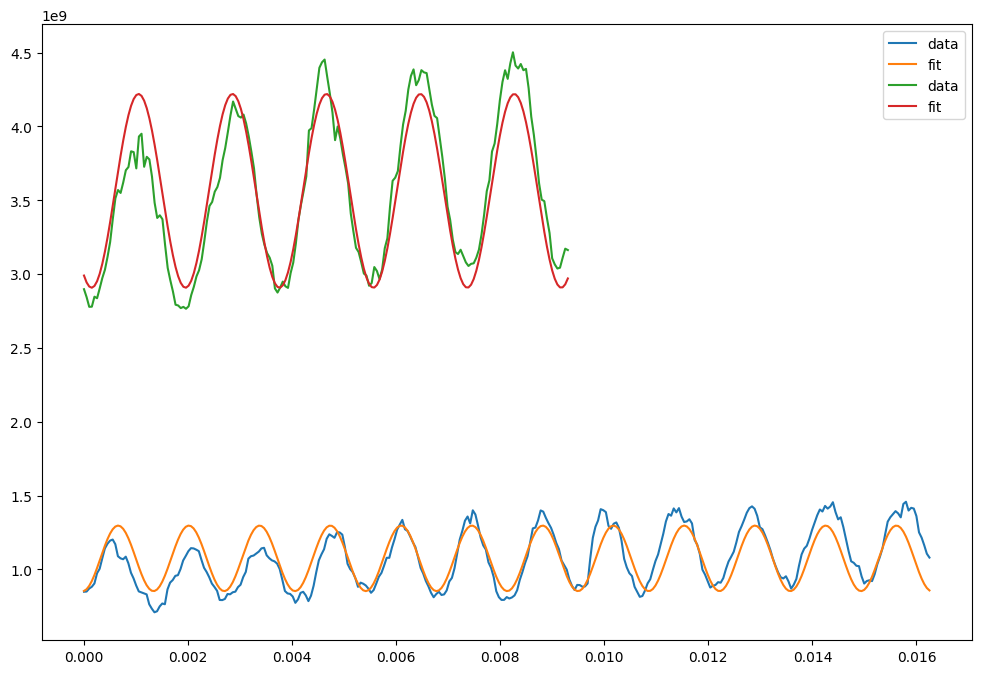

In [28]:
fig, ax1 = plt.subplots(figsize = (12,8))

ind = 2
intens = all_oam7_fork_intens[ind]

x = np.linspace(0,len(intens),len(intens))*pxl_to_m
ax1.plot(x,intens, label = "data")
ax1.plot(x, cosine_func(x,*oam7_fork_fitparams[ind]), label = "fit")

intens = all_oam7_nofork_intens[ind]

x = np.linspace(0,len(intens),len(intens))*pxl_to_m
ax1.plot(x,intens, label = "data")
ax1.plot(x, cosine_func(x,*oam7_nofork_fitparams[ind]), label = "fit")

ax1.legend()
plt.show()
plt.close(fig)

### Contrast Density Plot

In [29]:
plam_sum = np.sum(spec_data[:,1])

bin_height = 0.05 * plam_sum
bindices = [0]
running_sum = 0


for i, plam in enumerate(spec_data[:,1]):
    if running_sum > bin_height:
        bindices.append(i)
        running_sum = 0
    running_sum += plam
    
bindices.append(len(spec_data[:,1]))
bindices = np.repeat(bindices,2)[1:-1].reshape(len(bindices*2)//2 - 1,2) + reset_cutoff[0]

In [51]:
lam_oam4_imgs = []

for start, stop in bindices:
    lam_oam4_imgs.append([])
    for d in range(len(d_oam4)):
        
        lam_oam4_imgs[-1].append(Image.fromarray(np.sum([fits.open((oam4basepath + "%d" + "/datafiles/" + "oam4D00%d_0"\
        + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data / normed.T for i in range(start,stop)],\
        axis = 0)).rotate(oam4rotdegs[d]))


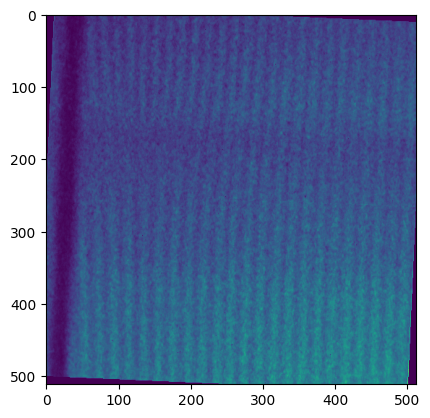

In [52]:
plt.imshow(np.array(lam_oam4_imgs[6][2]).T)
plt.show()

In [53]:
lam_oam7_imgs = []

for start, stop in bindices:
    lam_oam7_imgs.append([])
    for d in range(len(d_oam7)):
        lam_oam7_imgs[-1].append(Image.fromarray(np.sum([fits.open((oam7basepath + "0"*(3 - len(str(d))) + "%d/datafiles/" + "Dscan_" + "0"*(3 - len(str(d)))+ "%d_0"\
        + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data / normed.T for i in range(start,stop)],\
        axis = 0)).rotate(oam7rotdegs[d]))

In [54]:
lam_oam4_fork_subregion = [[np.array(img)[oam4forkranges[d][0]:oam4forkranges[d][1],10:30] for d, img in enumerate(img_list)] for img_list in lam_oam4_imgs]
lam_oam4_nofork_subregion = [[np.array(img)[oam4noforkranges[d][0]:oam4noforkranges[d][1],450:480] for d, img in enumerate(img_list)] for img_list in lam_oam4_imgs]

lam_oam4_fork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam4_fork_subregion]
lam_oam4_nofork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam4_nofork_subregion]

In [55]:
lam_oam7_fork_subregion = [[np.array(img)[oam7forkranges[d][0]:oam7forkranges[d][1],10:30] for d, img in enumerate(img_list)] for img_list in lam_oam7_imgs]
lam_oam7_nofork_subregion = [[np.array(img)[oam7noforkranges[d][0]:oam7noforkranges[d][1],450:480] for d, img in enumerate(img_list)] for img_list in lam_oam7_imgs]

lam_oam7_fork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam7_fork_subregion]
lam_oam7_nofork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam7_nofork_subregion]

In [56]:
lam_oam4_fork_fitparams, lam_oam4_fork_error = np.moveaxis([[best_fit_moire_period_with_error(cosine_func,\
                np.linspace(0,len(intens),len(intens))*pxl_to_m,intens, p, L, d_oam4[i]) for i, intens in enumerate(intens_list)]\
                for intens_list in lam_oam4_fork_intens],-2,0)

lam_oam4_nofork_fitparams, lam_oam4_nofork_error = np.moveaxis([[best_fit_moire_period_with_error(cosine_func,\
                np.linspace(0,len(intens),len(intens))*pxl_to_m,intens, p, L, d_oam4[i]) for i, intens in enumerate(intens_list)]\
                for intens_list in lam_oam4_nofork_intens], -2,0)

In [57]:
lam_oam7_fork_fitparams, lam_oam7_fork_error = np.moveaxis([[best_fit_moire_period_with_error(cosine_func,\
                np.linspace(0,len(intens),len(intens))*pxl_to_m,intens, p, L, d_oam7[i]) for i, intens in enumerate(intens_list)]\
                for intens_list in lam_oam7_fork_intens],-2,0)

lam_oam7_nofork_fitparams, lam_oam7_nofork_error = np.moveaxis([[best_fit_moire_period_with_error(cosine_func,\
                np.linspace(0,len(intens),len(intens))*pxl_to_m,intens, p, L, d_oam7[i]) for i, intens in enumerate(intens_list)]\
                for intens_list in lam_oam7_nofork_intens], -2,0)

/Users/macprorac2/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/macprorac2/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/macprorac2/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/macprorac2/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/macprorac2/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/macprorac2/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide


In [58]:
lam_oam4_nofork_error.shape

(20, 5, 4)

In [59]:
cont_oam4 = {"fork": np.abs(lam_oam4_fork_fitparams[...,1]/lam_oam4_fork_fitparams[...,0]), "nofork":\
             np.abs(lam_oam4_nofork_fitparams[...,1]/lam_oam4_nofork_fitparams[...,0])}

cont_oam7 = {"fork": np.abs(lam_oam7_fork_fitparams[...,1]/lam_oam7_fork_fitparams[...,0]), "nofork":\
             np.abs(lam_oam7_nofork_fitparams[...,1]/lam_oam7_nofork_fitparams[...,0])}


cont_oam7["fork"] = np.array([np.mean(cont_oam7["fork"][:,i:i+3], axis = -1) for i in range(cont_oam7["fork"].shape[-1] - 1)[::3]] +\
                    [cont_oam7["fork"][:,-1]]).T
cont_oam7["nofork"] = np.array([np.mean(cont_oam7["nofork"][:,i:i+3], axis = -1) for i in range(cont_oam7["nofork"].shape[-1] - 1)[::3]] +\
                    [cont_oam7["nofork"][:,-1]]).T



In [60]:
lam_endpoints = [[spec_data[start,0],spec_data[stop-1,0]] for start,stop in (bindices - reset_cutoff[0])]
lam_datapoints = np.mean(lam_endpoints, axis = 1)

lam_labels = ["[%.1f--%.1f]" % (spec_data[start,0],spec_data[stop-1,0]) for start,stop in (bindices - reset_cutoff[0])] 
d_oam4_labels = ["%.1f" % (d*1e3) for d in d_oam4]

In [83]:
[i for i in range(cont_oam7["fork"].shape[-1] - 1)[::3]]

[0, 3]

In [61]:
oam4_nofork_period_error = oam4_nofork_error[...,2]
oam4_fork_period_error = oam4_fork_error[...,2]

oam7_nofork_period_error = oam7_nofork_error[...,2]
oam7_fork_period_error = oam7_fork_error[...,2]


oam7_nofork_period_error = np.array([np.sqrt(np.sum(oam7_nofork_period_error[i:i+3]**2, axis = 0)) for i\
                        in range(oam7_nofork_period_error.shape[-1] - 1)[::3]] + [oam7_nofork_period_error[-1]]).T
oam7_fork_period_error = np.array([np.sqrt(np.sum(oam7_fork_period_error[i:i+3]**2, axis = 0)) for i\
                        in range(oam7_fork_period_error.shape[-1] - 1)[::3]] + [oam7_fork_period_error[-1]]).T


In [62]:
oam7_nofork_period_error

array([1.11903072e-05, 4.13328776e-06, 2.68777167e-06, 2.95352141e-06,
       2.85645674e-06])

In [64]:
cont_oam4["nofork"].shape
# np.min(np.diff(lam_endpoints))

(20, 5)

In [47]:
interp_lam = np.arange(spec_data[0,0], spec_data[-1,0],\
            np.min(np.diff(lam_endpoints)))
interp_cont_oam4 = np.array([np.interp(interp_lam, lam_datapoints, cont) for cont in cont_oam4["nofork"].T]).T
interp_cont_oam7 = np.array([np.interp(interp_lam, lam_datapoints, cont) for cont in cont_oam7["nofork"].T]).T
interplam_labels = ["%.1f" % i for i in interp_lam]

In [150]:
points_oam4 = np.reshape([[[i, j] for i in d_oam4] for j in lam_datapoints*1e-10], (-1,2))
vals_oam4 = np.reshape(cont_oam4["nofork"], (-1,))

lam_grid, d_grid = np.meshgrid(simlam, dsim)

In [151]:
np.reshape([[[i, j] for i in dsim] for j in simlam], (-1,2)).shape

(7372, 2)

In [156]:
interp2d_cont_oam4 = LinearNDInterpolator(points_oam4, vals_oam4)(d_grid, lam_grid)


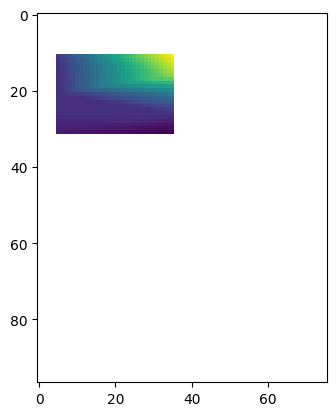

In [157]:
plt.imshow(interp2d_cont_oam4)

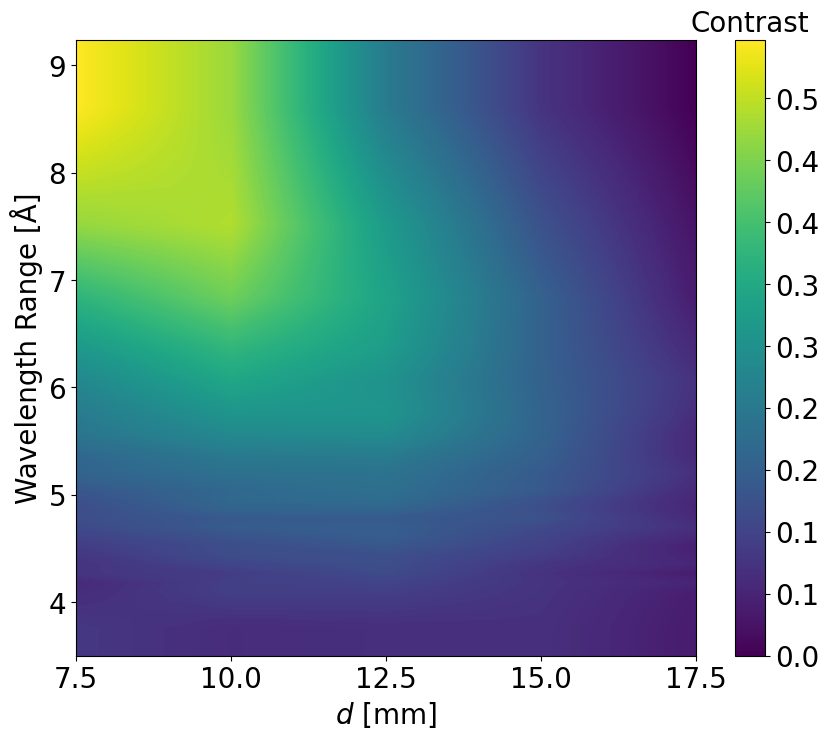

In [88]:
fig, ax = plt.subplots(figsize = (10,8))



c = ax.contourf(interp_cont_oam4, levels = 1000, extent = [d_oam4[0]*1e3, d_oam4[-1]*1e3, interp_lam[0], interp_lam[-1]])

cbar = fig.colorbar(c, format = "%.1f")
cbar.ax.tick_params(labelsize = 20)
cbar.ax.set_title("Contrast", fontsize = 20)


ax.set_xticks(d_oam4*1e3)
ax.set_xticklabels(d_oam4_labels, fontsize = 20)

ax.set_yticks(np.arange(4,10))
ax.set_yticklabels(np.arange(4,10), fontsize = 20)

ax.set_xlabel(r"$d$ [mm]", fontsize = 20)
ax.set_ylabel("Wavelength Range [Å]", fontsize = 20)



# fig.savefig("OAM4DataContrastDensity.png")
plt.show()
plt.close(fig)

In [43]:
d_oam7_labels = ["%.1f" % (d*1e3) for d in np.unique(d_oam7)]

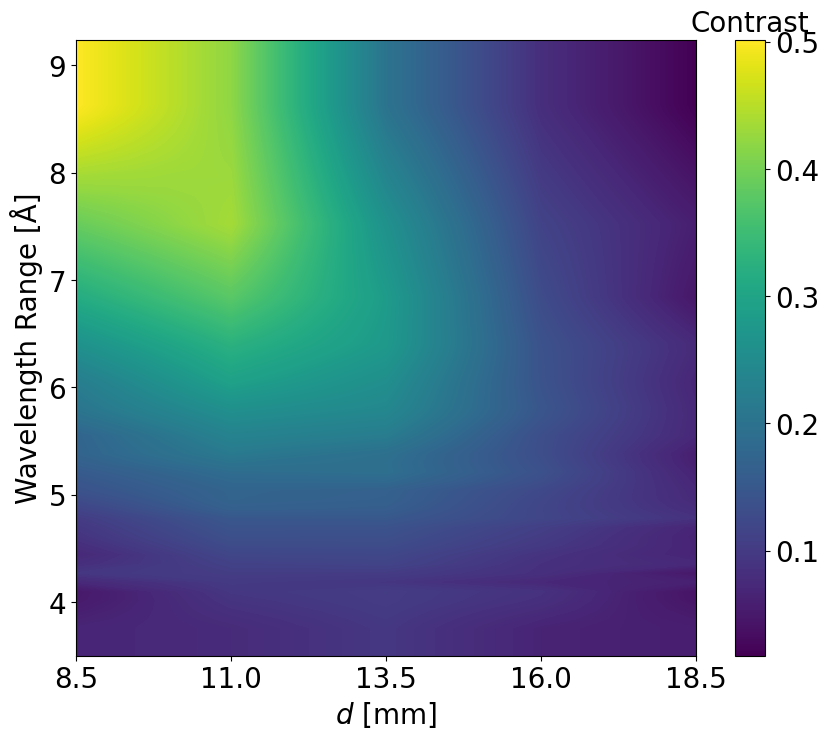

In [44]:
fig, ax = plt.subplots(figsize = (10,8))
c = ax.contourf(interp_cont_oam7, levels = 1000, extent = [d_oam7[0]*1e3, d_oam7[-1]*1e3, interp_lam[0], interp_lam[-1]])

cbar = fig.colorbar(c,format = "%.1f", ticks = np.arange(0,0.6, 0.1))
cbar.ax.tick_params(labelsize = 20)
cbar.ax.set_title("Contrast", fontsize = 20)


ax.set_xticks(np.unique(d_oam7)*1e3)
ax.set_xticklabels(d_oam7_labels, fontsize = 20)

ax.set_yticks(np.arange(4,10))
ax.set_yticklabels(np.arange(4,10), fontsize = 20)

ax.set_xlabel(r"$d$ [mm]", fontsize = 20)
ax.set_ylabel("Wavelength Range [Å]", fontsize = 20)



# fig.savefig("OAM7DataContrastDensity.png")

plt.show()
plt.close(fig)

In [172]:
p_oam4_fork = oam4_fork_fitparams[...,2]
p_oam4_nofork = oam4_nofork_fitparams[...,2]

oam4_fork_intens_fringes = np.array([len(i) for i in all_oam4_fork_intens]) * pxl_to_m / p_oam4_fork

oam4_fork_intens_fringes_error = oam4_fork_intens_fringes * oam4_fork_period_error / p_oam4_fork

oam4_nofork_intens_fringes = np.array([len(i) for i in all_oam4_nofork_intens]) * pxl_to_m / p_oam4_nofork

oam4_nofork_intens_fringes_error = oam4_nofork_intens_fringes * oam4_nofork_period_error / p_oam4_nofork


measured_oam_oam4 = oam4_fork_intens_fringes - oam4_nofork_intens_fringes

measured_oam_oam4_error = measured_oam_oam4 * np.sqrt(oam4_fork_intens_fringes_error**2 + oam4_nofork_intens_fringes_error**2)


In [173]:
oam4_fork_period_error

array([2.53708631e-06, 1.44166889e-06, 1.19552630e-06, 1.24493480e-06,
       1.59056513e-06])

In [174]:
p_oam7_fork = oam7_fork_fitparams[...,2]

p_oam7_fork = np.array([np.mean(p_oam7_fork[i:i+3]) for i in range(len(d_oam7) - 1)[::3]] + [p_oam7_fork[-1]])

p_oam7_nofork = oam7_nofork_fitparams[...,2]

p_oam7_nofork = np.array([np.mean(p_oam7_nofork[i:i+3]) for i in range(len(d_oam7) - 1)[::3]] + [p_oam7_nofork[-1]])


oam7_fork_intens_fringes = np.array([np.mean([len(j) for j in all_oam7_fork_intens[i:i+3]]) for i in range(len(d_oam7) - 1)[::3]]\
                        + [len(all_oam7_fork_intens[-1])]) * pxl_to_m / p_oam7_fork

oam7_fork_intens_fringes_error = oam7_fork_intens_fringes * oam7_fork_period_error / p_oam7_fork


oam7_nofork_intens_fringes = np.array([np.mean([len(j) for j in all_oam7_nofork_intens[i:i+3]]) for i in range(len(d_oam7) - 1)[::3]]
                        + [len(all_oam7_nofork_intens[-1])]) * pxl_to_m / p_oam7_nofork

oam7_nofork_intens_fringes_error = oam7_nofork_intens_fringes * oam7_nofork_period_error / p_oam7_nofork

measured_oam_oam7 = oam7_fork_intens_fringes - oam7_nofork_intens_fringes

measured_oam_oam7_error = measured_oam_oam7 * np.sqrt(oam7_fork_intens_fringes_error**2 + oam7_nofork_intens_fringes_error**2)


In [175]:
oam7_fork_period_error

array([4.72913135e-06, 2.54148348e-06, 1.73260776e-06, 1.76226143e-06,
       1.50204294e-06])

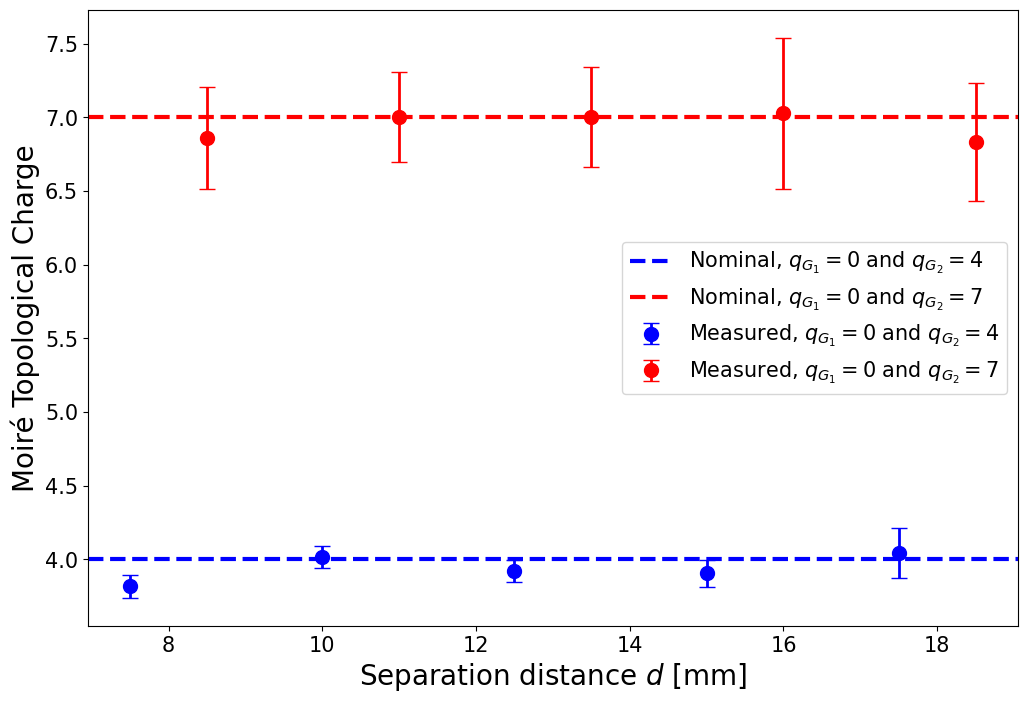

In [177]:
fig, ax1 = plt.subplots(figsize = (12,8))

colours = ["blue","red"]
ax1.set_prop_cycle(color = colours)
ax1.errorbar((d_oam4)*1e3,measured_oam_oam4, fmt = "o", yerr = measured_oam_oam4_error, capsize = 6,\
             label = r"Measured, $q_{G_1} = 0$ and $q_{G_2} = 4$", markersize = 10, elinewidth = 2)

ax1.errorbar((d_oam4+1e-3)*1e3,measured_oam_oam7, fmt = "o", yerr = measured_oam_oam7_error, capsize = 6,\
             label = r"Measured, $q_{G_1} = 0$ and $q_{G_2} = 7$", markersize = 10, elinewidth = 2)


ax1.axhline(4,ls = "--", color = colours[0],label = "Nominal, $q_{G_1} = 0$ and $q_{G_2} = 4$", linewidth = 3)
ax1.axhline(7,ls = "--", color = colours[1],label = "Nominal, $q_{G_1} = 0$ and $q_{G_2} = 7$", linewidth = 3)

ax1.set_xlabel(r"Separation distance $d$ [mm]", fontsize = 20)
ax1.set_ylabel("Moiré Topological Charge", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

ax1.legend(fontsize = 15)
fig.savefig("OAMMeasuredvsNominal.png")
plt.show()
plt.close(fig)

### Simulations

In [30]:

x0 = np.array([0])
mt = 5

Nbc = 5e28*4.149e-15


camsize = 512 * pxl_to_m

simlam = np.linspace(3,15,76)*1e-10

xbin = 1e-6/9
ybin = 1e-6/9

slitx = 500e-6
slity = 500e-6

res = pxl_to_m

# ROIx = np.array([-1,1])*3/5 * 1e-2
# ROIy = np.array([-275e-6, 275e-6]) + 0.75*camsize

# camsizex = np.diff(ROIx)[0]

dsim = np.linspace(2,50,97)*1e-3
# dsim = d_oam4[1:3]


lam = np.array([5e-10])
plam = np.ones_like(lam)

phi = Nbc*h*lam

G1sd = {"p":p, "L1": np.array([L1]), "phi":phi, "mt" : mt, "spectrum_spacing":1}

G1sd["L2"] = dsim



G2sd = {"p":p, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi, "OAM":4, "mt" : mt, "spectrum_spacing":1}
G2sd["L2"] = L - (G1sd["L1"] + G1sd["L2"])


simapts = {"G1":RectGrating(G1sd),"G2":ForkGrating(G2sd)}


siminit = {"lam":lam, "plam":plam, "sum_lam":False, "L":L,"d":G1sd["L2"],"mt":mt, "x": np.linspace(-camsize/6, camsize/6,\
            int(camsize/3/xbin)),"y": np.linspace(-camsize/6, camsize/6, int(camsize/3/ybin)), "p" : p,"xbin":xbin,\
            "ybin":ybin, "slitx":slitx, "slity":slity,"camsize" : camsize ,"convmode" : "valid", "resx": res, "resy": res,\
            "batches" : 64}

In [ ]:
t0 = time()
simLANL = PGMI(simapts,siminit)
simLANL.propagate_to("G1")
simLANL.propagate_to("G2")
simLANL.intensity_fit("G2")
print(time() - t0, "seconds")

(64, 64, 2, 1200, 1200) after generating raw
(2, 64, 1200, 64, 1200) before reshape
(2, 76800, 76800) after reshape


In [ ]:
# np.save("simoam4intensd=%.1fmm.npy"%(dsim*1e3),simLANL.intensity)

In [ ]:
plt.imshow(simLANL.intensity[0].T, origin = "lower")
plt.show()

In [7]:
t0 = time()
contdens = []
# intensdens = []

for i,lami in enumerate(simlam):
    
    lami = np.array([lami])
    phi = Nbc*h*lami


    G1sd = {"p":p, "L1": np.array([L1]), "phi":phi}

    G1sd["L2"] = dsim



    G2sd = {"p":p, "L1": G1sd["L1"] +  G1sd["L2"], "phi":phi, "OAM":7, "mt" : mt}
    G2sd["L2"] = L - (G1sd["L1"] + G1sd["L2"])


    simapts = {"G1":RectGrating(G1sd),"G2":ForkGrating(G2sd)}
    siminit = {"lam":lami, "plam": np.ones(1), "L":L,"d":G1sd["L2"],"mt":mt, "x": np.linspace(*ROIx,(np.diff(ROIx)/xbin).astype(int)[0] +1),\
                   "y": np.linspace(*ROIy,(np.diff(ROIy)/ybin).astype(int)[0]+1), "x0" : x0,"xbin":xbin,"ybin":ybin,"slitx":slitx, "slity":slity,\
               "pos":np.array([[0],[1]]) ,"camsize" : camsizex ,"convmode" : "valid", "res": res, "batches" : 2000}
    clear_output(wait = True)
    print(100*i/len(simlam), "% done")
    
    simLANL = PGMI(simapts,siminit)
    simLANL.propagate_to("G1")
    simLANL.propagate_to("G2")
    simLANL.generate_after("G2")
    contdens.append(simLANL.contrast)
    # intensdens.append(simLANL.intensity)

print(time() - t0, "seconds")

98.6842105263158 % done
(2000, 97, 9, 551) after parallel
(97, 2000, 9, 551) before reshape
(97, 18000, 551) after reshape
28939.061904907227 seconds


In [8]:
contdens = np.squeeze(contdens)

In [71]:
contOAM4dens = np.load("contOAM4_vs_lam_vs_d.npy")
contOAM7dens = np.load("contOAM7_vs_lam_vs_d.npy")

In [72]:
np.linspace(3,15,76)

array([ 3.  ,  3.16,  3.32,  3.48,  3.64,  3.8 ,  3.96,  4.12,  4.28,
        4.44,  4.6 ,  4.76,  4.92,  5.08,  5.24,  5.4 ,  5.56,  5.72,
        5.88,  6.04,  6.2 ,  6.36,  6.52,  6.68,  6.84,  7.  ,  7.16,
        7.32,  7.48,  7.64,  7.8 ,  7.96,  8.12,  8.28,  8.44,  8.6 ,
        8.76,  8.92,  9.08,  9.24,  9.4 ,  9.56,  9.72,  9.88, 10.04,
       10.2 , 10.36, 10.52, 10.68, 10.84, 11.  , 11.16, 11.32, 11.48,
       11.64, 11.8 , 11.96, 12.12, 12.28, 12.44, 12.6 , 12.76, 12.92,
       13.08, 13.24, 13.4 , 13.56, 13.72, 13.88, 14.04, 14.2 , 14.36,
       14.52, 14.68, 14.84, 15.  ])

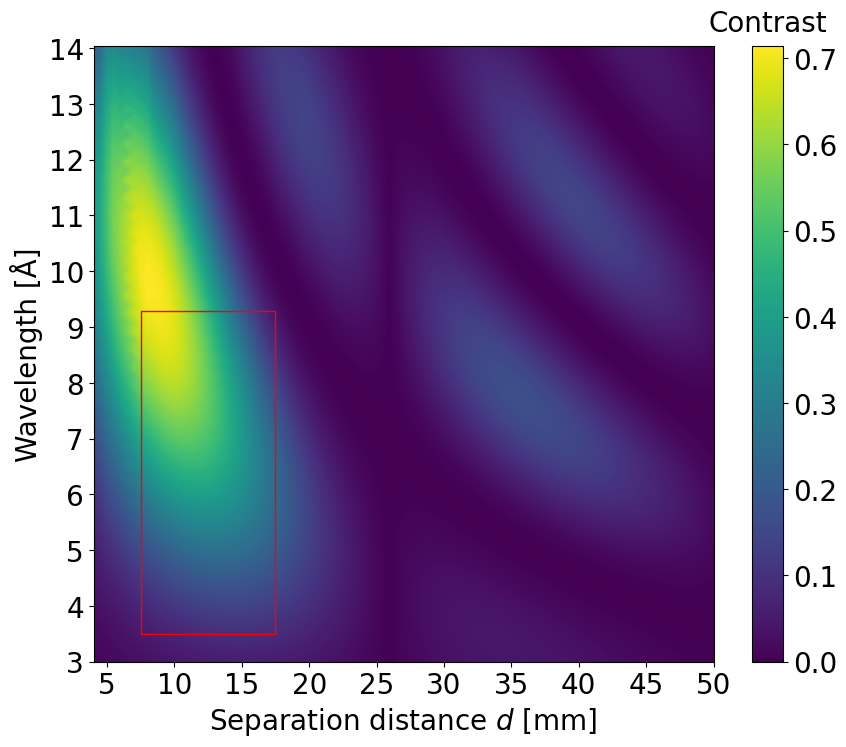

In [107]:
fig, ax = plt.subplots(figsize = (10,8))

lam_for_fig = spec_data[...,0]

c = ax.contourf(contOAM4dens[:-6,4:], extent = (dsim[4], dsim[-1], simlam[0]*1e10, simlam[-7]*1e10),levels = 1000)

rect = Rectangle([d_oam4[0],np.min(lam_for_fig)],\
    d_oam4[-1] - d_oam4[0], np.max(lam_for_fig)-np.min(lam_for_fig),linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

cbar = fig.colorbar(c, format = "%.1f")
cbar.set_ticks(np.arange(0,0.8,0.1))
cbar.ax.tick_params(labelsize = 20)
cbar.ax.set_title("Contrast", fontsize = 20, y = 1.01)

ax.set_yticks(np.arange(3,15,1))
ax.set_yticklabels(np.arange(3,15,1), fontsize = 20)
ax.set_xticks(dsim[6::10])
ax.set_xticklabels((dsim[6::10]*1e3).round().astype(int), fontsize = 20)


ax.set_xlabel(r"Separation distance $d$ [mm]", fontsize = 20)
ax.set_ylabel(r"Wavelength [Å]", fontsize = 20)

fig.savefig("OAM4SimulationContrastDensity.png")
plt.show()
plt.close(fig)

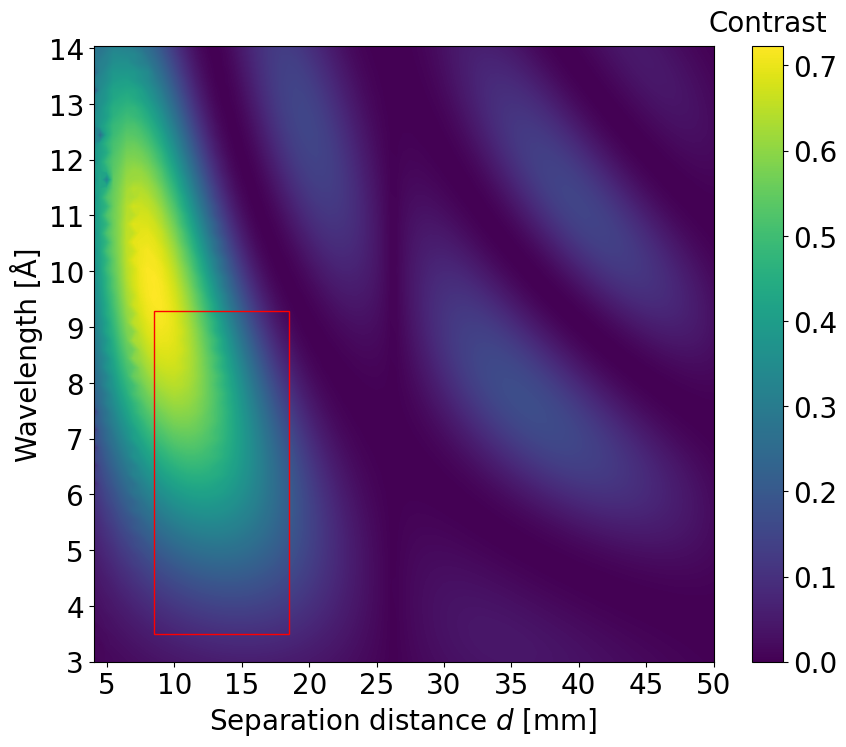

In [108]:
fig, ax = plt.subplots(figsize = (10,8))


c = ax.contourf(contOAM7dens[:-6,4:], extent = (dsim[4], dsim[-1], simlam[0]*1e10, simlam[-7]*1e10),levels = 1000)

rect = Rectangle([d_oam7[0],np.min(lam_for_fig)],\
    d_oam7[-1] - d_oam7[0], np.max(lam_for_fig)-np.min(lam_for_fig),linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

cbar = fig.colorbar(c, format = "%.1f")
cbar.set_ticks(np.arange(0,0.8,0.1))
cbar.ax.tick_params(labelsize = 20)
cbar.ax.set_title("Contrast", fontsize = 20, y = 1.01)

ax.set_yticks(np.arange(3,15,1))
ax.set_yticklabels(np.arange(3,15,1), fontsize = 20)
ax.set_xticks(dsim[6::10])
ax.set_xticklabels((dsim[6::10]*1e3).round().astype(int), fontsize = 20)


ax.set_xlabel(r"Separation distance $d$ [mm]", fontsize = 20)
ax.set_ylabel(r"Wavelength [Å]", fontsize = 20)

fig.savefig("OAM7SimulationContrastDensity.png")
plt.show()
plt.close(fig)

### PSI Broken Monochromator

In [3]:
def maxwell_k(Tc,mass, N_points):
    a = np.sqrt(1.38e-23*Tc/(mass))
    v_dist = maxwell(scale = a)
    q_mass = 1.05457e-34/mass
    k_vals = np.linspace(v_dist.ppf(0.1),v_dist.ppf(0.999),N_points) / q_mass
    return np.asarray([k_vals, np.sqrt(2/pi)*q_mass*q_mass/(a*a*a)*k_vals*k_vals*np.exp(-k_vals*k_vals*q_mass*q_mass/(2*a*a))])

def maxk_raw(k,Tc):
    a = np.sqrt(1.38e-23*Tc/(1.675e-27))
    q_mass = 1.05457e-34/1.675e-27
    return np.sqrt(2/pi)*q_mass*q_mass/(a*a*a)*k*k*np.exp(-k*k*q_mass*q_mass/(2*a*a))
    

In [502]:

# measured = pd.read_excel("NG6_Spectrum_FinalCorrections.xlsx").to_numpy().T
# measured[0]*=1e-9
# calculated = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
# calculated[0]*=1e-9
# k_maxwell40 = maxwell_k(40,1.675e-27,len(measured[0]))
# k_maxwell5A = maxwell_k(19.52,1.675e-27,len(measured[0]))

# norm = 1.05457e-34/1.675e-27 # h-bar over neutron mass 


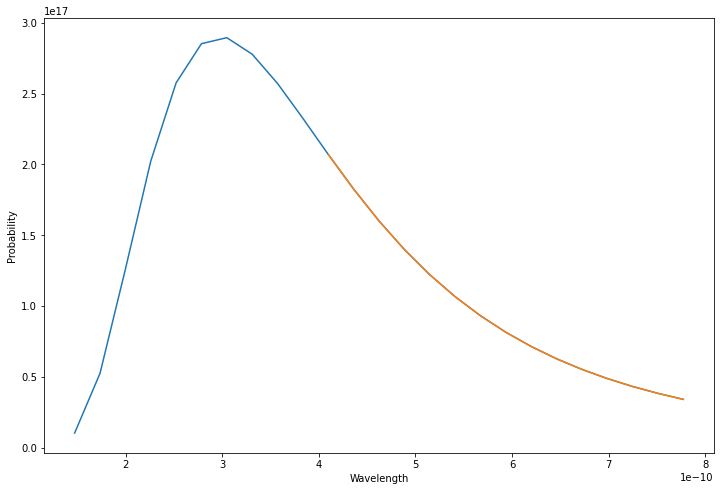

In [16]:
# Tm = (6.626e-34**2)/(2*1.38e-23*1.675e-27*(0.3e-9**2))
Tm = 53.8
print(Tm)

maxwell3 = maxwell_k(Tm,1.675e-27,25)

lams3 = np.linspace(2*pi/maxwell3[0][0],2*pi/maxwell3[0][-1], len(maxwell3[0]))
lams4 = lams3[:np.where(lams3 < 4e-10)[0][0]]
km3 = 2*pi/lams3
km4 = 2*pi/lams4

plam3 = maxk_raw(km3,Tm)*km3**2
plam4 = maxk_raw(km4,Tm)*km4**2


fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(lams3,plam3)

ax1.plot(lams4,plam4)
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Probability")
plt.show()
# print(lams3[np.argmax(plam3)]*5e28*4.149e-15*8.53e-6)